## Streaming data from multiple collections

Streaming data for the same spatial location (same bbox) from multiple collections.

In [ ]:
import pystac_client
url = 'https://datacube.services.geo.ca/stac/api/'
catalog = pystac_client.Client.open(url)  

Lets use the **hrdem-lidar** and **landcover** collections.

In [17]:
collections = ['mrdem-30', 'landcover']

The **landcover** collection has a meaningful temporal dimension, lets filter on date. 

In [22]:
# Define filter for STAC request
datetime_range = '2015-01-01/2025-12-31'
bbox = [-114.00, 51.24, -113.94, 51.33]

Search the STAC API endpoint to retrieve the STAC items that may be available for those filters.

In [23]:
stac_items = catalog.search(collections = collections, 
                            bbox = bbox, 
                            datetime = datetime_range)

GDAL GetGeoTransform and rasterio use different formats for transform metadata. The order expected in the STAC proj:transform is the same as reported by rasterio. When using GDAL method you need to re-order the proj:transform
comming from the STAC metadata to be able to load the pystac object into array. 

In [24]:
def reorder_transform(gdal_transform):
    """
    Reorders the GDAL GeoTransform (6-element tuple) into the 9-element format
    that is compatible with proj:transform.
    """
    return [gdal_transform[1], gdal_transform[2], gdal_transform[0],
            gdal_transform[4], gdal_transform[5], gdal_transform[3], 
            0, 0, 1]

# Create list 
list_items = []
# Use pagination
for page in stac_items.pages():
	for item in page:
                proj_transform = item.properties["proj:transform"]
                item.properties["proj:transform"] = reorder_transform(proj_transform)
                list_items.append(item)

Create a dictionary where the keys will be the names of the collections, and the values will be a list of asset that we want to read from each collection.

In [25]:
# Use pagination
for page in stac_items.pages():
        for item in page:
                print(item.assets.keys())
                print(item.get_collection().id)

dict_keys(['dsm', 'dtm', 'source', 'dsm-vrt', 'dtm-vrt', 'thumbnail', 'source-vrt', 'hillshade-dsm', 'hillshade-dtm', 'hillshade-dsm-vrt', 'hillshade-dtm-vrt'])
mrdem-30
dict_keys(['thumbnail', 'classification'])
landcover
dict_keys(['thumbnail', 'classification'])
landcover


In [26]:
# Based on the previous result, build your dictionnary with the asset needed
collections_dict = {"mrdem-30" : ['dsm', 'dtm'], "landcover" : ['classification']}

Load the pystac-client items into xarray, and merge them afterwards. 
`odc.stac` or `stackstac` can be used at this point.

In [27]:
# Using odc.stac
import odc.stac

datasets = []

for item in list_items:
    ds = odc.stac.load(
        [item],
        chunks = {"x": 1000, "y": 1000},
        bands = collections_dict[item.collection_id],
        bbox = bbox,
        resolution = 1.0)
        
    datasets.append(ds)    

print(datasets)

[<xarray.Dataset> Size: 590MB
Dimensions:      (y: 10713, x: 6887, time: 1)
Coordinates:
  * y            (y) float64 86kB 4.527e+05 4.527e+05 ... 4.42e+05 4.42e+05
  * x            (x) float64 55kB -1.297e+06 -1.297e+06 ... -1.29e+06 -1.29e+06
    spatial_ref  int32 4B 3979
  * time         (time) datetime64[ns] 8B 2024-12-12T12:00:00
Data variables:
    dsm          (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    dtm          (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>, <xarray.Dataset> Size: 295MB
Dimensions:         (y: 10713, x: 6887, time: 1)
Coordinates:
  * y               (y) float64 86kB 4.527e+05 4.527e+05 ... 4.42e+05 4.42e+05
  * x               (x) float64 55kB -1.297e+06 -1.297e+06 ... -1.29e+06
    spatial_ref     int32 4B 3979
  * time            (time) datetime64[ns] 8B 2020-07-01T12:00:00
Data variables:
    classification  (time, y, x) float32 295MB dask.array<chunksize=(1, 1000, 1000), meta

Merge them into a single dataset that contains all the data variables.

Time is not an important variable for me, and it is the only dimension varying among my data items. All data items have the same x and y coordinates but different time values, which I do not need.

In [31]:
import xarray

multi_collection = xarray.merge(datasets)

In [29]:
multi_collection

<xarray.Dataset> Size: 3GB
Dimensions:         (y: 10713, x: 6887, time: 3)
Coordinates:
  * y               (y) float64 86kB 4.527e+05 4.527e+05 ... 4.42e+05 4.42e+05
  * x               (x) float64 55kB -1.297e+06 -1.297e+06 ... -1.29e+06
  * time            (time) datetime64[ns] 24B 2015-07-01T12:00:00 ... 2024-12...
    spatial_ref     int32 4B 3979
Data variables:
    dsm             (time, y, x) float32 885MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    dtm             (time, y, x) float32 885MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    classification  (time, y, x) float32 885MB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

Use the landcover to mask the water pixels from the mrdem-30.

In [32]:
multi_collection = multi_collection.compute()

In [33]:
multi_collection

<xarray.Dataset> Size: 3GB
Dimensions:         (y: 10713, x: 6887, time: 3)
Coordinates:
  * y               (y) float64 86kB 4.527e+05 4.527e+05 ... 4.42e+05 4.42e+05
  * x               (x) float64 55kB -1.297e+06 -1.297e+06 ... -1.29e+06
  * time            (time) datetime64[ns] 24B 2015-07-01T12:00:00 ... 2024-12...
    spatial_ref     int32 4B 3979
Data variables:
    dsm             (time, y, x) float32 885MB nan nan ... 1.113e+03 1.113e+03
    dtm             (time, y, x) float32 885MB nan nan ... 1.113e+03 1.113e+03
    classification  (time, y, x) float32 885MB 15.0 15.0 15.0 ... nan nan nan

Visualize the results! 

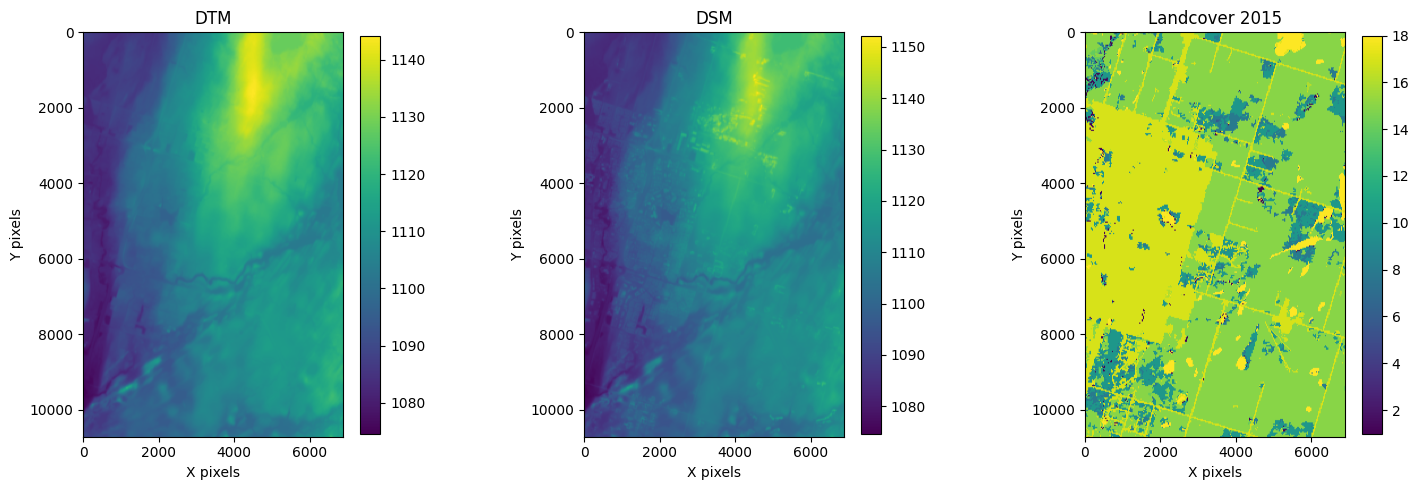

In [38]:
import rasterio
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figure size as needed
arrays = [multi_collection["dtm"].data[2, :, :], multi_collection["dsm"].data[2, :, :], multi_collection["classification"].data[0, :, :]]
titles = ["DTM", "DSM", "Landcover 2015"]

for ax, arr, title in zip(axes, arrays, titles):
    img = ax.imshow(arr, cmap="viridis") 
    ax.set_title(title)
    ax.set_xlabel("X pixels")
    ax.set_ylabel("Y pixels")
    fig.colorbar(img, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()
